# Predicción de enfermedades cardiovasculares

## 1. Preparación

In [3]:
# Se importan las bibliotecas necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

import joblib

from sklearn.model_selection import cross_val_score




In [4]:
# Se configura el estilo de los gráficos
plt.style.use('ggplot')


In [5]:
# Se cargan los datos
data_url = "content/framingham_clean.csv"
data = pd.read_csv(data_url)

## 2. Análisis Exploratorio de los Datos

### 2.1. Análisis superficial

In [6]:
# Se muestran las primeras filas del dataset
data.head()

# Resumen general del dataset
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         4240 non-null   int64  
 1   gender             4240 non-null   int64  
 2   age                4240 non-null   int64  
 3   education          4240 non-null   int64  
 4   currentSmoker      4240 non-null   int64  
 5   cigsPerDay         4240 non-null   int64  
 6   BPMeds             4240 non-null   object 
 7   prevalentStroke    4240 non-null   int64  
 8   prevalentHyp       4240 non-null   int64  
 9   diabetes           4240 non-null   int64  
 10  totChol            4240 non-null   int64  
 11  sysBP              4240 non-null   float64
 12  diaBP              4240 non-null   float64
 13  BMI                4240 non-null   float64
 14  heartRate          4240 non-null   int64  
 15  glucose            4240 non-null   int64  
 16  TenYearCHD         4240 

In [7]:
# Resumen estadístico
summary_stats = data.describe()
print(summary_stats)


       Unnamed: 0       gender          age    education  currentSmoker  \
count   4240.0000  4240.000000  4240.000000  4240.000000    4240.000000   
mean    2119.5000     0.429245    49.580189     1.955189       0.494104   
std     1224.1269     0.495027     8.572942     1.018522       0.500024   
min        0.0000     0.000000    32.000000     1.000000       0.000000   
25%     1059.7500     0.000000    42.000000     1.000000       0.000000   
50%     2119.5000     0.000000    49.000000     2.000000       0.000000   
75%     3179.2500     1.000000    56.000000     3.000000       1.000000   
max     4239.0000     1.000000    70.000000     4.000000       1.000000   

        cigsPerDay  prevalentStroke  prevalentHyp     diabetes      totChol  \
count  4240.000000      4240.000000   4240.000000  4240.000000  4240.000000   
mean      8.944340         0.005896      0.310613     0.025708   236.667689   
std      11.904777         0.076569      0.462799     0.158280    44.328480   
min     

In [8]:
# Verificación de valores faltantes
missing_values = data.isnull().sum()
print("Valores faltantes por columna:\n", missing_values)


Valores faltantes por columna:
 Unnamed: 0           0
gender               0
age                  0
education            0
currentSmoker        0
cigsPerDay           0
BPMeds               0
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol              0
sysBP                0
diaBP                0
BMI                  0
heartRate            0
glucose              0
TenYearCHD           0
age_groups           0
heart_rate_groups    0
dtype: int64


In [9]:
# Verificación de valores duplicados
duplicated_values = data.duplicated().sum()
print("Valores duplicados por columna:\n", duplicated_values)

Valores duplicados por columna:
 0


### 2.2. Preprocesado de los Datos

In [10]:
# Limpieza de datos
# Reemplazar 'Missing' por 2 en BPMeds
data['BPMeds'] = data['BPMeds'].replace('Missing', 2)
# Convertir BPMeds a numérico
data['BPMeds'] = pd.to_numeric(data['BPMeds'])


In [11]:
# Convertir gender a texto
data['gender'] = data['gender'].astype(str).replace(['0', '1'], ['M', 'F'])

# Convertir currentSmoker a texto
data['currentSmoker'] = data['currentSmoker'].astype(str).replace(['0', '1'], ['NO', 'YES'])

# Verificar tipos de datos después de la limpieza
print(data.dtypes)


Unnamed: 0             int64
gender                object
age                    int64
education              int64
currentSmoker         object
cigsPerDay             int64
BPMeds                 int64
prevalentStroke        int64
prevalentHyp           int64
diabetes               int64
totChol                int64
sysBP                float64
diaBP                float64
BMI                  float64
heartRate              int64
glucose                int64
TenYearCHD             int64
age_groups             int64
heart_rate_groups      int64
dtype: object


### 2.3. Análisis Univariado

In [12]:
# Crear gráficos de barras para variables categóricas
categorical_vars = ['gender','education','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes']

for var in categorical_vars:
  print(var,":")
  print(data[var].value_counts())
  print("------------------")



gender :
gender
M    2420
F    1820
Name: count, dtype: int64
------------------
education :
education
1    1825
2    1253
3     689
4     473
Name: count, dtype: int64
------------------
currentSmoker :
currentSmoker
NO     2145
YES    2095
Name: count, dtype: int64
------------------
BPMeds :
BPMeds
0    4063
1     124
2      53
Name: count, dtype: int64
------------------
prevalentStroke :
prevalentStroke
0    4215
1      25
Name: count, dtype: int64
------------------
prevalentHyp :
prevalentHyp
0    2923
1    1317
Name: count, dtype: int64
------------------
diabetes :
diabetes
0    4131
1     109
Name: count, dtype: int64
------------------


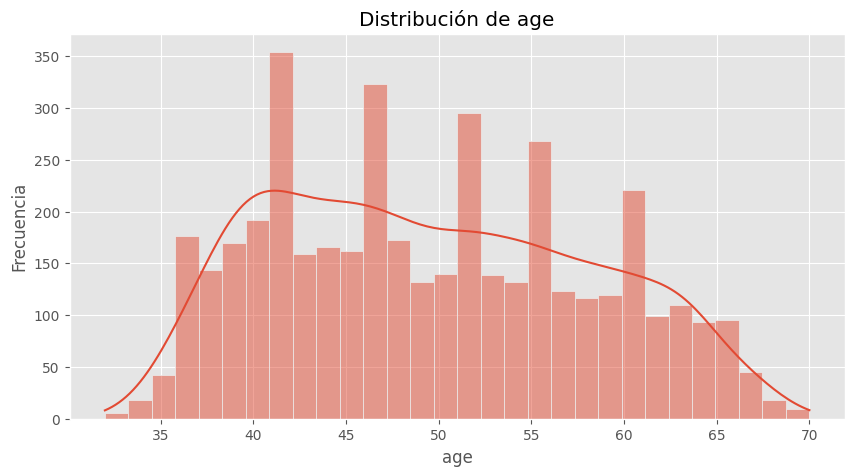

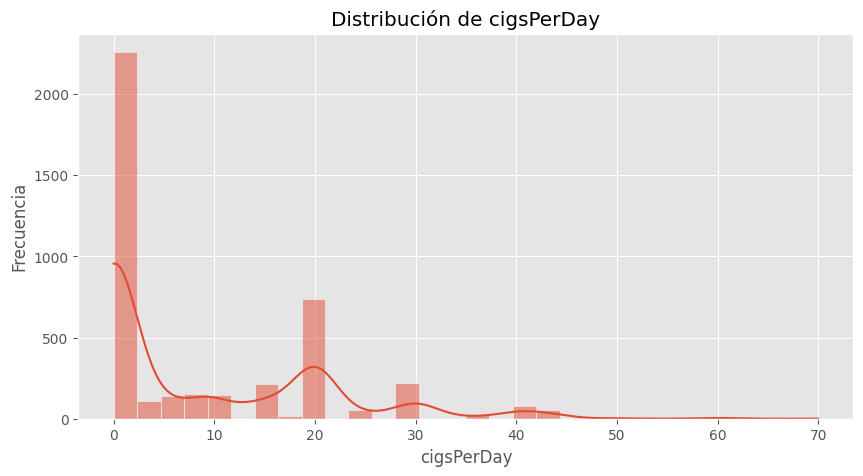

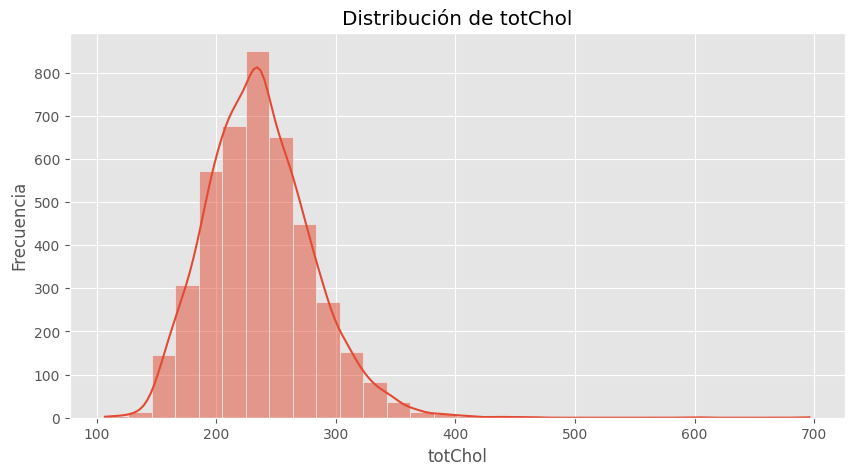

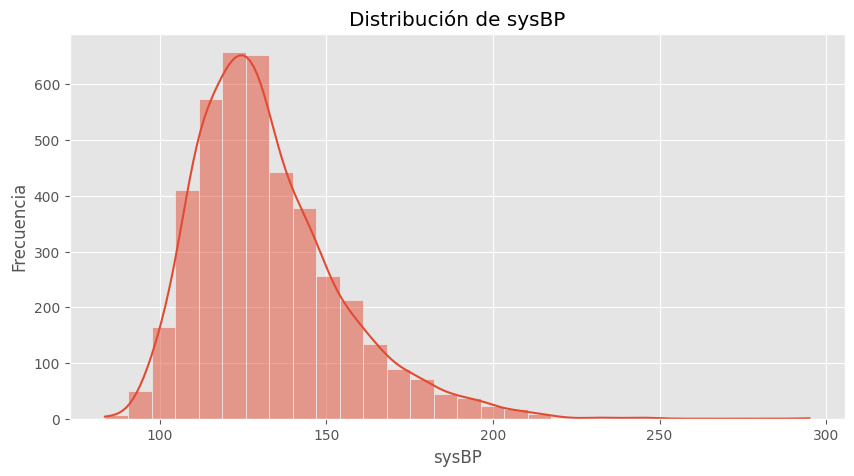

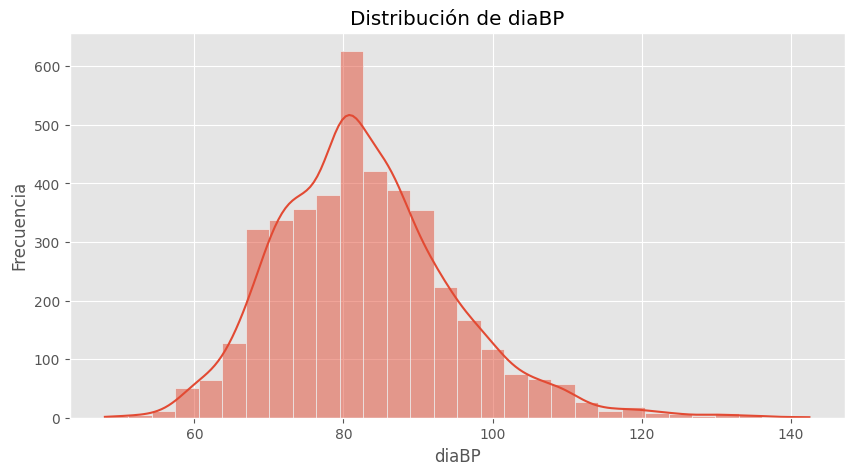

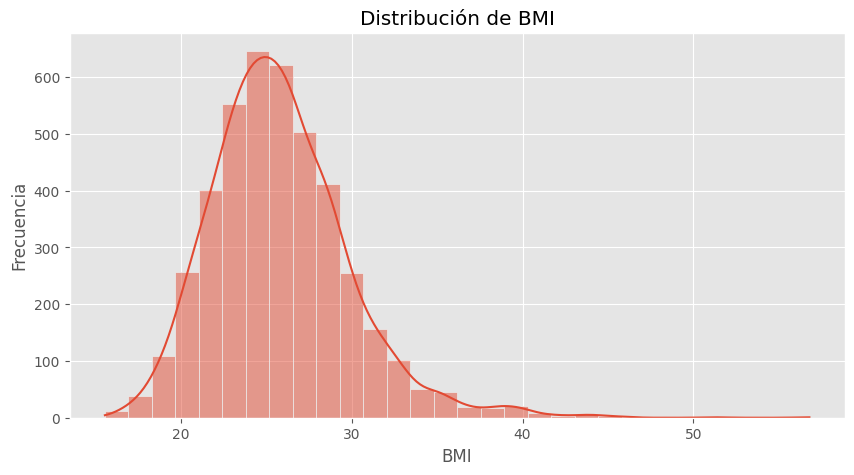

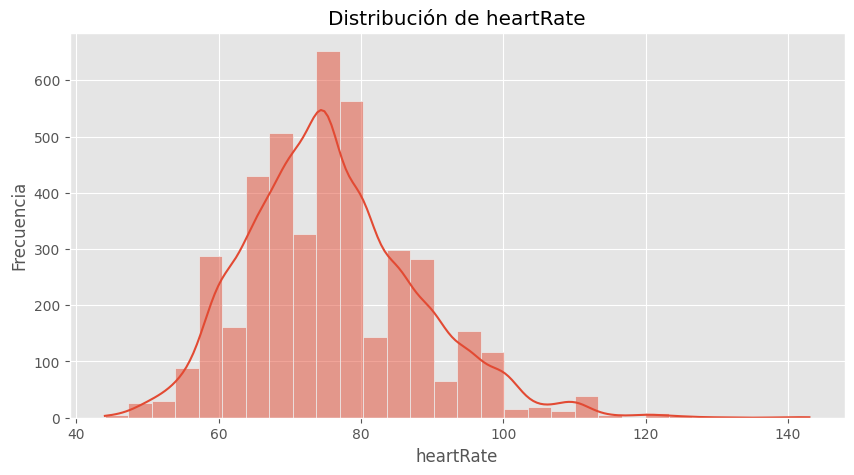

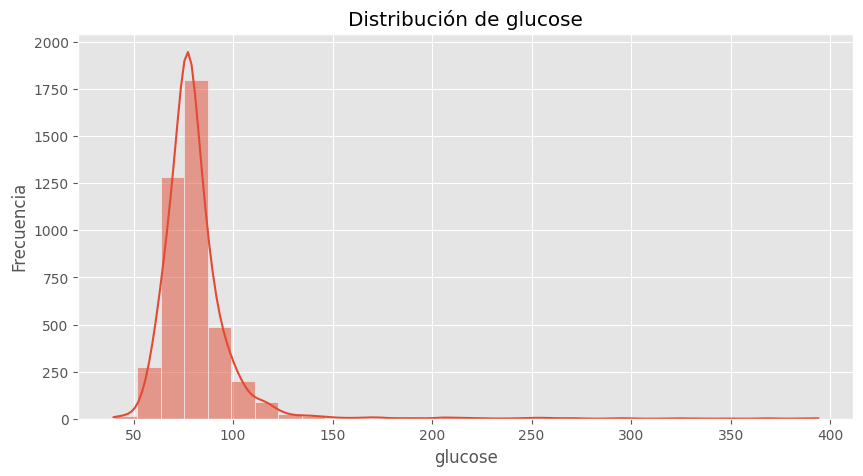

In [13]:
# Crear histogramas y gráficos de densidad para variables numéricas
numeric_vars = ["age","cigsPerDay","totChol","sysBP","diaBP","BMI","heartRate","glucose"]

for var in numeric_vars:
    plt.figure(figsize=(10, 5))
    sns.histplot(data[var], kde=True, bins=30)
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.show()

<ipython-input-14-f43c082ddeac>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data['TenYearCHD'] == 0]['age'], label='Sin enfermedades cardiovasculares')
<ipython-input-14-f43c082ddeac>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data['TenYearCHD'] == 1]['age'], label = 'Con en

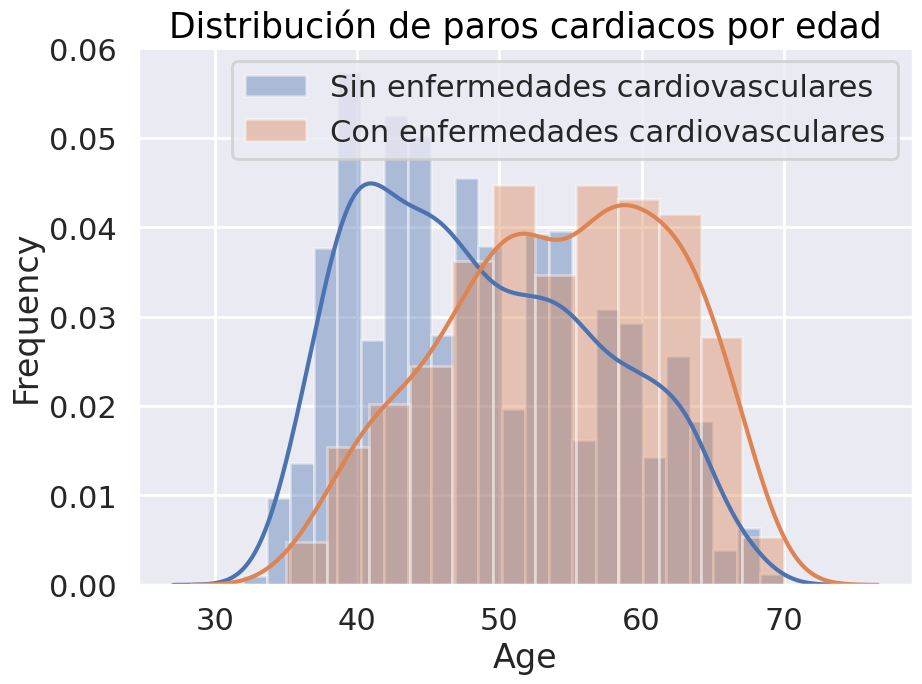

In [14]:
# Distribución de paros cardiacos según la edad
sns.set_theme(context='poster')
plt.figure(figsize=(10,7))
plt.title('Distribución de paros cardiacos por edad', color="Black",fontsize=25)

sns.distplot(data[data['TenYearCHD'] == 0]['age'], label='Sin enfermedades cardiovasculares')
sns.distplot(data[data['TenYearCHD'] == 1]['age'], label = 'Con enfermedades cardiovasculares')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

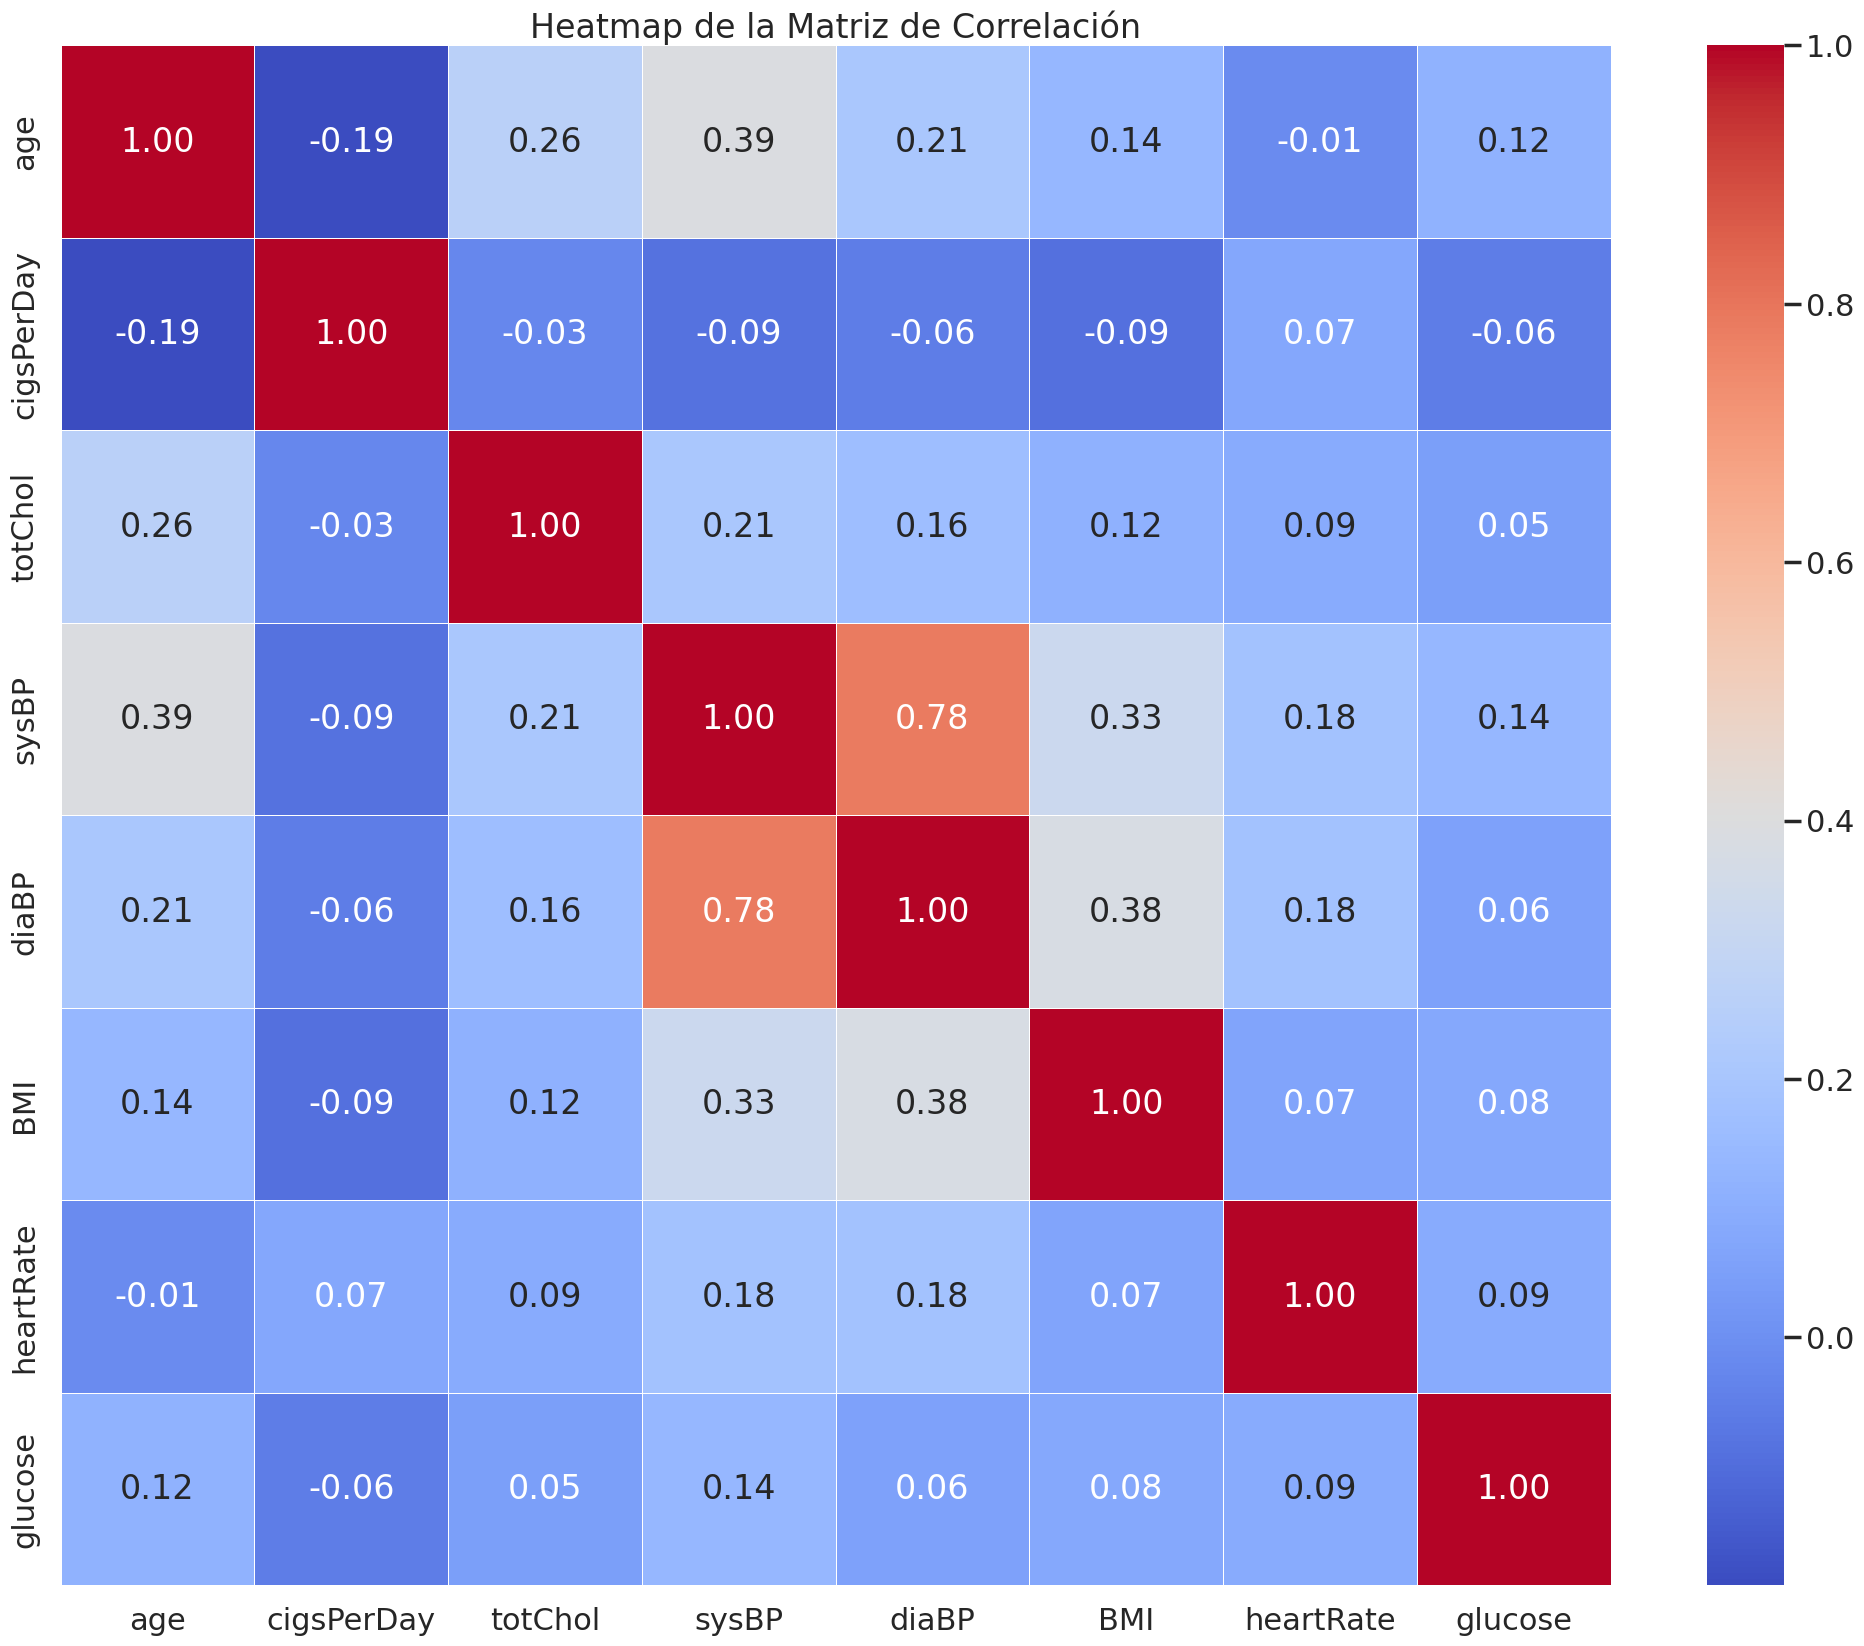

In [15]:
# Matriz de correlación y heatmap
# Solo  columnas numéricas
correlation_matrix = data[numeric_vars].corr()

plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap de la Matriz de Correlación')
plt.show()

### 2.4. Análisis Bivariado

In [16]:
# Variable objetivo
target_var = 'TenYearCHD'  # Se reemplaza con la columna objetivo
data["TenYearCHD"].value_counts(normalize=True)

,proportion
TenYearCHD,
0,0.848113
1,0.151887


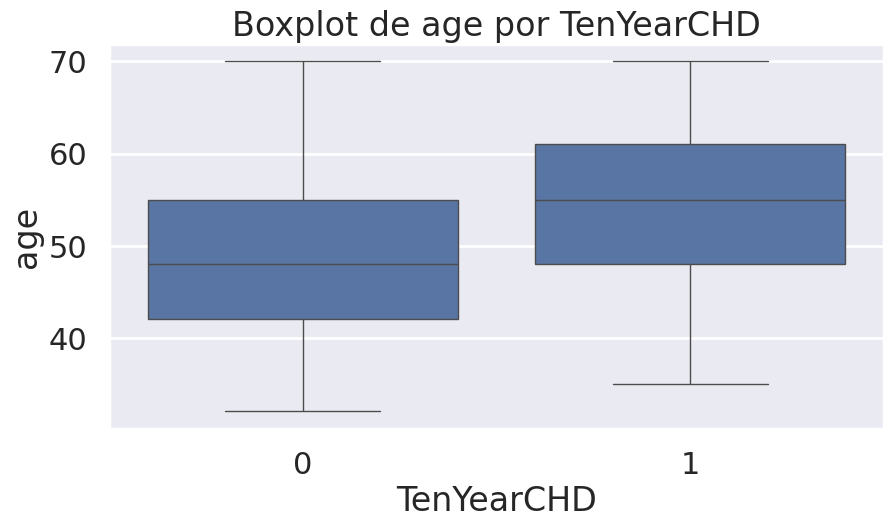

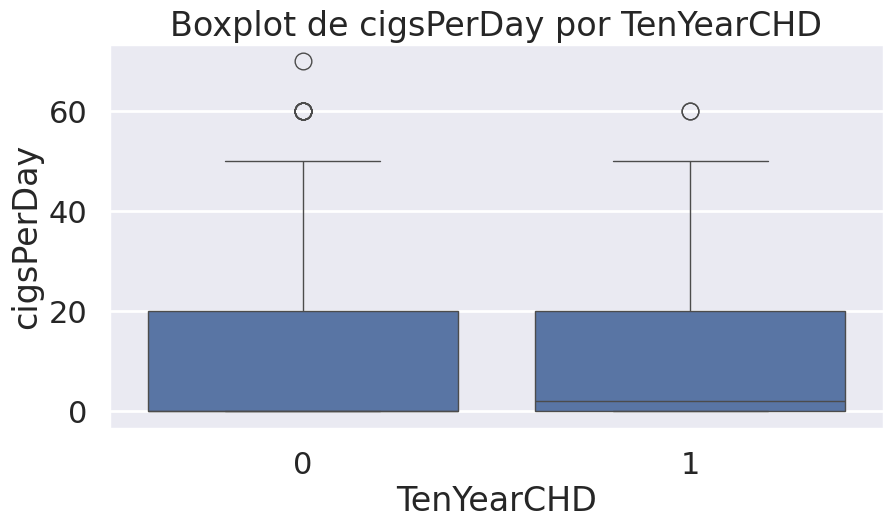

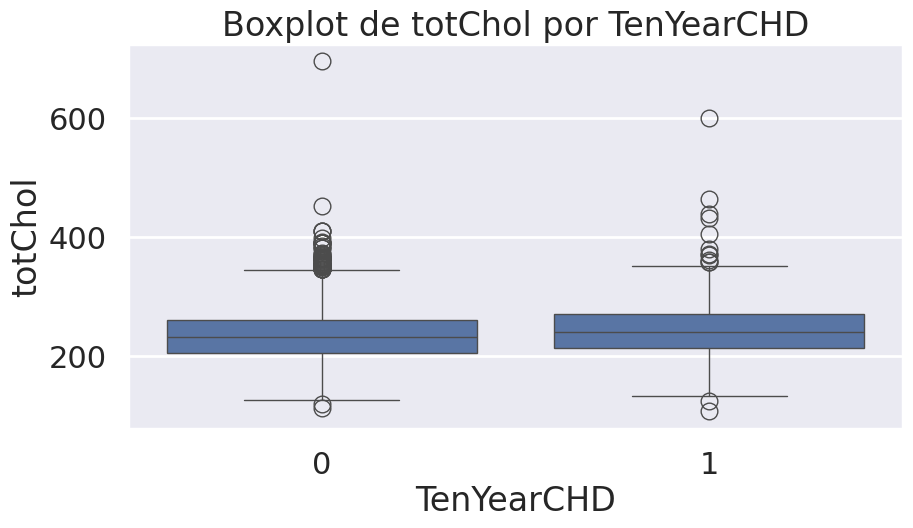

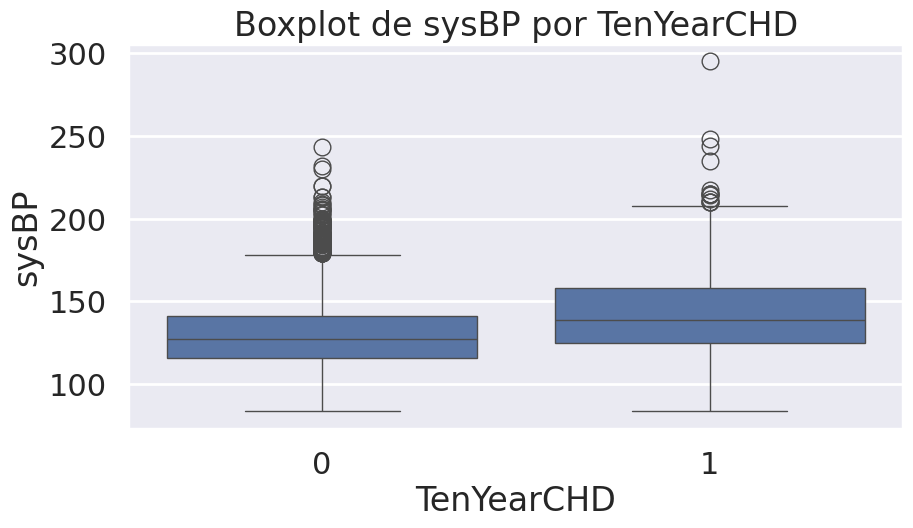

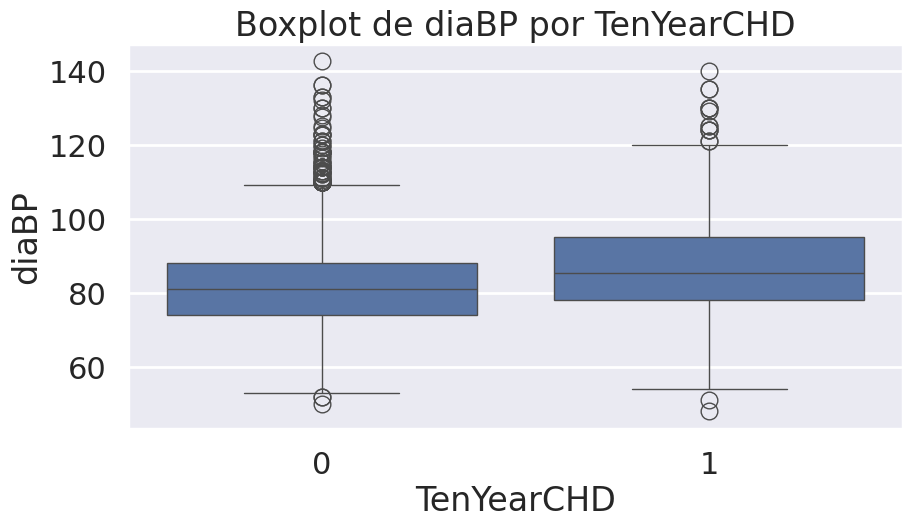

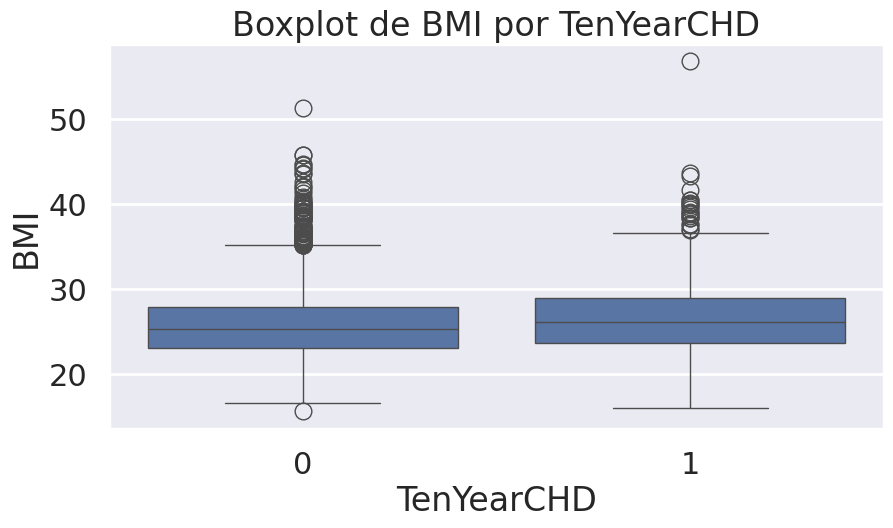

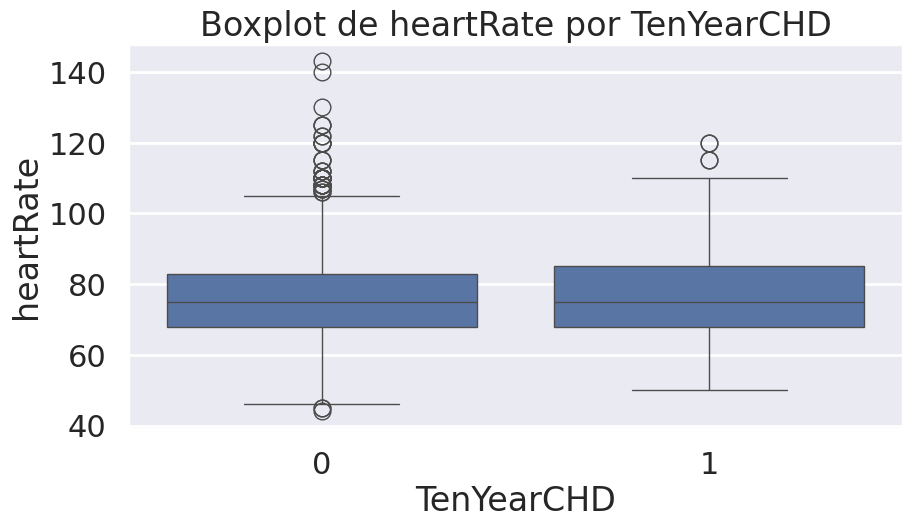

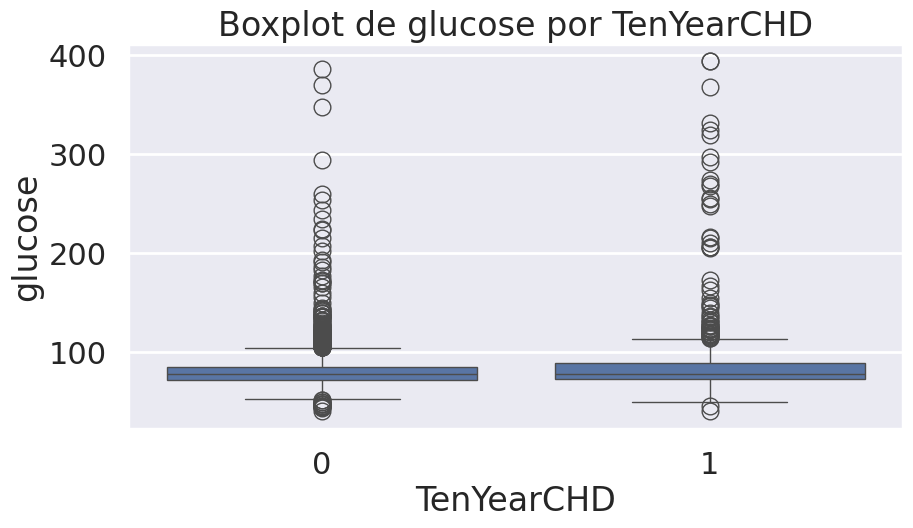

In [17]:
# Crear gráficos de cajas y violines para variables numéricas por grupo de TenYearCHD
for var in numeric_vars:
    if var != target_var:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=target_var, y=var, data=data)
        plt.title(f'Boxplot de {var} por {target_var}')
        plt.xlabel(target_var)
        plt.ylabel(var)
        plt.show()


In [18]:
# Análisis de relaciones categóricas con TenYearCHD usando tablas de contingencia y chi-cuadrado
def chi_square_test(var):
    contingency_table = pd.crosstab(data[var], data[target_var])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return contingency_table, chi2, p

In [19]:
# Variables categóricas a analizar
categorical_vars_for_chi2 = ['gender', 'currentSmoker', 'education', 'prevalentStroke', 'prevalentHyp', 'diabetes']

for var in categorical_vars_for_chi2:
    contingency_table, chi2, p = chi_square_test(var)
    print(f'Tabla de contingencia para {var}:\n', contingency_table)
    print(f'Estadístico chi-cuadrado: {chi2}')
    print(f'Valor p: {p}\n')

Tabla de contingencia para gender:
 TenYearCHD     0    1
gender               
F           1477  343
M           2119  301
Estadístico chi-cuadrado: 32.61833491071199
Valor p: 1.1215175755662674e-08

Tabla de contingencia para currentSmoker:
 TenYearCHD        0    1
currentSmoker           
NO             1834  311
YES            1762  333
Estadístico chi-cuadrado: 1.4972035438574873
Valor p: 0.2211021442164888

Tabla de contingencia para education:
 TenYearCHD     0    1
education            
1           1486  339
2           1106  147
3            601   88
4            403   70
Estadístico chi-cuadrado: 31.051850034062287
Valor p: 8.289453270159487e-07

Tabla de contingencia para prevalentStroke:
 TenYearCHD          0    1
prevalentStroke           
0                3582  633
1                  14   11
Estadístico chi-cuadrado: 14.033657261599943
Valor p: 0.0001795675785918809

Tabla de contingencia para prevalentHyp:
 TenYearCHD       0    1
prevalentHyp           
0             

## 5. Modelos y predicciones

### 5.1. Preparación de los datos para el modelo

In [23]:
# Se separan características y variable objetivo
X = data.drop(columns=['TenYearCHD', 'Unnamed: 0'])
y = data['TenYearCHD']

# Convertir las columnas categóricas a numéricas
data['gender'] = data['gender'].astype(str).replace(['0', '1'], ['M', 'F'])
data['currentSmoker'] = data['currentSmoker'].astype(str).replace(['0', '1'], ['NO', 'YES'])

# Convertir variables categóricas a numéricas
data['gender'] = data['gender'].replace({'M': 0, 'F': 1}).astype(int)
data['currentSmoker'] = data['currentSmoker'].replace({'NO': 0, 'YES': 1}).astype(int)

# Preprocesamiento de datos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_vars),
        ('cat', categorical_transformer, categorical_vars)
    ])

# Se aplica el preprocesamiento
X_processed = preprocessor.fit_transform(X)

### 5.2. Regresión Logística

In [21]:
# División del dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000))])

clf.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluar el modelo
classification_report_result = classification_report(y_test, y_pred)
confusion_matrix_result = confusion_matrix(y_test, y_pred)
roc_auc_result = roc_auc_score(y_test, y_pred_proba)

print("Classification Report:\n", classification_report_result)
print("Confusion Matrix:\n", confusion_matrix_result)
print("ROC-AUC Score:\n", roc_auc_result)

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92       725
           1       0.59      0.08      0.14       123

    accuracy                           0.86       848
   macro avg       0.73      0.54      0.53       848
weighted avg       0.82      0.86      0.81       848

Confusion Matrix:
 [[718   7]
 [113  10]]
ROC-AUC Score:
 0.7102663302495094


### 5.3. Preparación de los datos para el modelo otra vez

In [ ]:
# Se separan características y variable objetivo
X = data.drop(columns=['TenYearCHD', 'Unnamed: 0'])
y = data['TenYearCHD']

# Convertir las columnas categóricas a numéricas
data['gender'] = data['gender'].astype(str).replace(['0', '1'], ['M', 'F'])
data['currentSmoker'] = data['currentSmoker'].astype(str).replace(['0', '1'], ['NO', 'YES'])

# Convertir variables categóricas a numéricas
data['gender'] = data['gender'].replace({'M': 0, 'F': 1}).astype(int)
data['currentSmoker'] = data['currentSmoker'].replace({'NO': 0, 'YES': 1}).astype(int)

# Preprocesamiento de datos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_vars),
        ('cat', categorical_transformer, categorical_vars)
    ])

# Se aplica el preprocesamiento
X_processed = preprocessor.fit_transform(X)

 ### 5.4. Random Forest con SMOTE

In [24]:
# Balanceo de clases usando SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# División del dataset balanceado en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Se crea y entrena el modelo de Random Forest
rf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', RandomForestClassifier(random_state=42))])

# Ajuste de hiperparámetros
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

# Se evalua el modelo
classification_report_result = classification_report(y_test, y_pred)
confusion_matrix_result = confusion_matrix(y_test, y_pred)
roc_auc_result = roc_auc_score(y_test, y_pred_proba)

print("Classification Report:\n", classification_report_result)
print("Confusion Matrix:\n", confusion_matrix_result)
print("ROC-AUC Score:\n", roc_auc_result)


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87       745
           1       0.85      0.89      0.87       694

    accuracy                           0.87      1439
   macro avg       0.87      0.87      0.87      1439
weighted avg       0.87      0.87      0.87      1439

Confusion Matrix:
 [[637 108]
 [ 79 615]]
ROC-AUC Score:
 0.9464876312786492


## 6. Validación de los modelos

Guardado del Modelo

In [ ]:
# Se guarda el modelo entrenado
joblib.dump(rf, 'best_random_forest_model.pkl')

# Cargar el modelo entrenado (ejemplo de cómo cargarlo más tarde)
# loaded_model = joblib.load('best_random_forest_model.pkl')


['best_random_forest_model.pkl']

Validación Adicional


In [ ]:
# Validación cruzada con 5 folds
cv_scores = cross_val_score(rf, X_resampled, y_resampled, cv=5, scoring='roc_auc')

print("Cross-Validation ROC-AUC Scores:", cv_scores)
print("Mean ROC-AUC Score:", cv_scores.mean())


Cross-Validation ROC-AUC Scores: [0.8632041  0.95642675 0.96111312 0.96812719 0.96795987]
Mean ROC-AUC Score: 0.9433662057357003


Revisión de predicciones y el análisis de casos correctos e incorrectos

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred = grid_search.predict(X_test)
y_test_pred_proba = grid_search.predict_proba(X_test)[:, 1]

# Crear un DataFrame para comparar las predicciones con los valores reales
predictions_comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Predicted_Probability': y_test_pred_proba
})

# Mostrar las primeras filas del DataFrame
print(predictions_comparison.head(10))

# Filtrar los casos donde el modelo predijo correctamente y donde falló
correct_predictions = predictions_comparison[predictions_comparison['Actual'] == predictions_comparison['Predicted']]
incorrect_predictions = predictions_comparison[predictions_comparison['Actual'] != predictions_comparison['Predicted']]

print("Correct Predictions:\n", correct_predictions.head())
print("Incorrect Predictions:\n", incorrect_predictions.head())


      Actual  Predicted  Predicted_Probability
4054       0          0                  0.455
3813       0          0                  0.355
5065       1          1                  0.765
4339       1          1                  0.855
1615       0          0                  0.300
4076       1          1                  0.925
5380       1          1                  0.885
132        0          1                  0.520
308        0          0                  0.160
5163       1          1                  0.845
Correct Predictions:
       Actual  Predicted  Predicted_Probability
4054       0          0                  0.455
3813       0          0                  0.355
5065       1          1                  0.765
4339       1          1                  0.855
1615       0          0                  0.300
Incorrect Predictions:
       Actual  Predicted  Predicted_Probability
132        0          1                  0.520
3768       1          0                  0.280
6032       1  

Análisis de Importancia de Características:

Determina cuáles características están influyendo más en las predicciones del modelo.

Feature Importances:
                    Feature  Importance
0                 num__age    0.138332
3               num__sysBP    0.136810
4               num__diaBP    0.115973
2             num__totChol    0.110842
5                 num__BMI    0.098211
7             num__glucose    0.097863
6           num__heartRate    0.094909
1          num__cigsPerDay    0.073045
10        cat__education_1    0.022239
14    cat__currentSmoker_0    0.014130
15    cat__currentSmoker_1    0.013669
8            cat__gender_0    0.011618
9            cat__gender_1    0.011614
13        cat__education_4    0.011390
11        cat__education_2    0.009016
21     cat__prevalentHyp_0    0.008181
22     cat__prevalentHyp_1    0.008100
12        cat__education_3    0.007215
16           cat__BPMeds_0    0.004458
17           cat__BPMeds_1    0.003146
24         cat__diabetes_1    0.003128
23         cat__diabetes_0    0.002832
18           cat__BPMeds_2    0.001803
20  cat__prevalentStroke_1    0.000756
19 

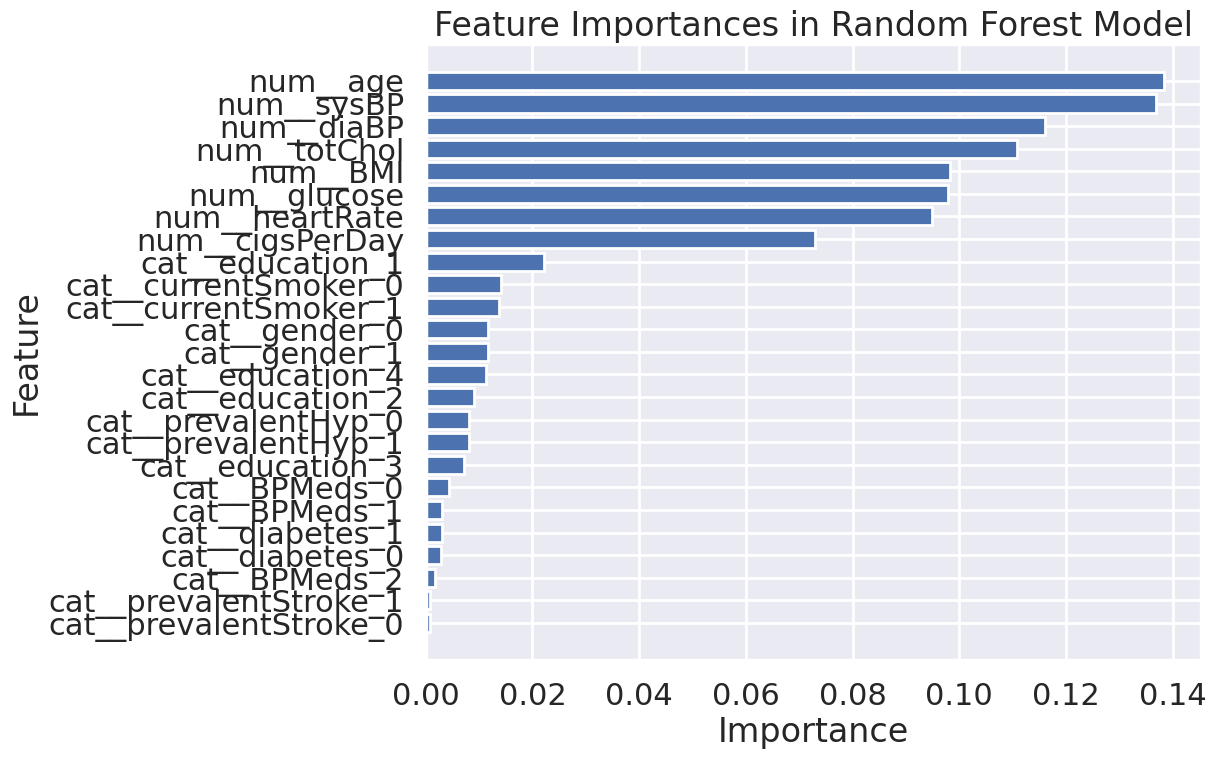

In [ ]:
# Obtener el preprocesador y el modelo ajustado
preprocessor = best_model.named_steps['preprocessor']
rf_model = best_model.named_steps['classifier']

# Obtener los nombres de las características transformadas
features = preprocessor.get_feature_names_out()

# Importancia de características
importances = rf_model.feature_importances_

# Crear un DataFrame con las características y sus importancias
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print("Feature Importances:\n", feature_importances)

# Visualización de la importancia de características
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

Guardado del modelo nuevamente

In [ ]:
# Guardar el modelo entrenado
joblib.dump(best_model, 'best_random_forest_model.pkl')

# Cargar el modelo entrenado (ejemplo de cómo cargarlo más tarde)
# loaded_model = joblib.load('best_random_forest_model.pkl')


['best_random_forest_model.pkl']